In [1]:
import rocket_casadi
import control
import matplotlib.pyplot as plt
import numpy as np

0 states have been removed from the model
3 states have been removed from the model
0 states have been removed from the model
5.3266587668672924 15.423262912373218 43.89454246748842 13.597077923014613
1
max delay 0.0197973947597971 s
Minimum freq required 50.51169672237464 Hz
gain margin 14.529097523407177 dB
8.172621605551754 11.967348564221169 48.34601949821576 13.377789017126236
2
max delay 0.015613165592018285 s
Minimum freq required 64.0485104770308 Hz
gain margin 18.247227828797726 dB
90.58857468512979 6.043887279911019 136.03760804293645 12.993016368402024
3
max delay 0.008118648484918735 s
Minimum freq required 123.17321064677303 Hz
gain margin 39.1414685309982 dB


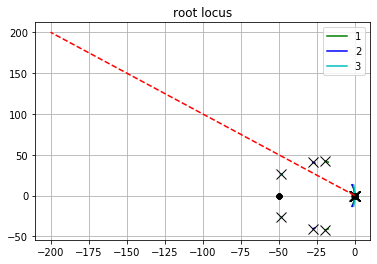

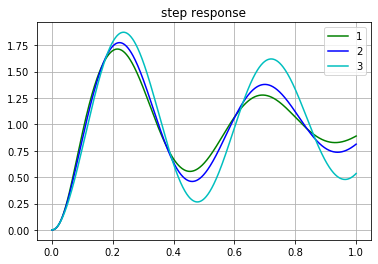

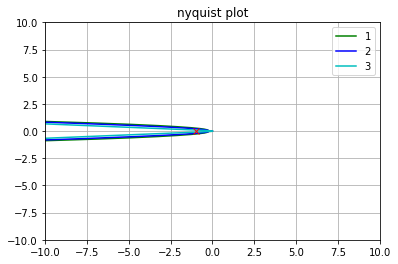

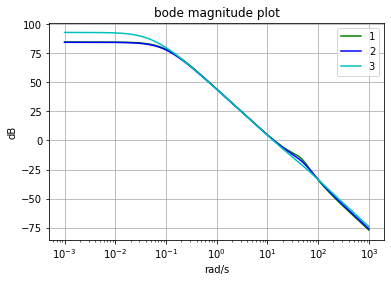

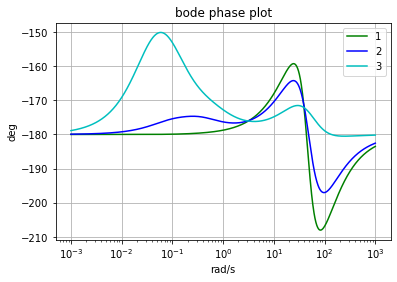

In [125]:
trim_points = [
    {'vt': 100, 'gamma_deg': 90, 'm_fuel': 0.8, 'color':'g', 'name':'1'},
    {'vt': 100, 'gamma_deg': 45, 'm_fuel': 0.5, 'color':'b', 'name':'2'},
    {'vt': 100, 'gamma_deg': 0, 'm_fuel': 0.2, 'color': 'c', 'name':'3'},
]

s = control.tf([1, 0], [0, 1])

# One Controller to rule them all, One Controller to find them,
# One Controller to bring them all, and in the rocket bind them
# H= 10*(s/100+1)*(s/100+1)/s  
# H = (5*s+50)/((s)*(s+5))
#H = (140*(s+60)*(s+60))/(s*(2138*s + 20008.8))
H = 140*(s+50)*(s+50)/(s*(2138*s + 208.8))

Go_list = []
for trim_point in trim_points:

    vt = trim_point['vt']
    gamma_deg = trim_point['gamma_deg']
    m_fuel = trim_point['m_fuel']

    x0, u0, p0 = rocket_casadi.do_trim(vt=vt, gamma_deg=gamma_deg, m_fuel=m_fuel)
    sys = control.ss(*rocket_casadi.linearize()(x0, u0, p0))

    G = sys[1, 2]/s;
    Go = control.minreal(G*H)
    Go_list.append(Go)

plt.figure()
plt.title('root locus')
handles = []
names = []
for trim_point, Go in zip(trim_points, Go_list):
    locus, omega = control.rlocus(Go, kvect=np.linspace(0, 1, 1000), Plot=False)
    handles.append(plt.plot(np.real(locus), np.imag(locus), color=trim_point['color'])[0])
    names.append(trim_point['name'])
    plt.plot(np.real(control.pole(Go)), np.imag(control.pole(Go)), 'kx', markersize='10')
    plt.plot(np.real(control.zero(Go)), np.imag(control.zero(Go)), 'ko', markersize='5')
plt.legend(handles, names)
plt.grid() 
plt.plot([0, -200], [0, 200], 'r--')

plt.figure()
plt.title('step response')
for trim_point, Go in zip(trim_points, Go_list):
    Gc = control.feedback(Go)
    t, y = control.step_response(Gc, T=np.linspace(0, 1, 1000))
    plt.plot(t, y, trim_point['color'], label=trim_point['name'])
plt.grid()
plt.legend()

plt.figure()
plt.title('nyquist plot')
for trim_point, Go in zip(trim_points, Go_list):
    real, imag, freq = control.nyquist(Go, omega=np.logspace(-3, 3, 1000), Plot=False)
    plt.plot(real, imag, trim_point['color'])
    plt.plot(real, -imag, trim_point['color'], label=trim_point['name'])
plt.plot(-1, 0, 'rx')
plt.grid()
plt.axis([-10, 10, -10, 10])
plt.legend()

plt.figure()
plt.title('bode magnitude plot')
for trim_point, Go in zip(trim_points, Go_list):
    mag, phase, omega = control.bode(Go, omega=np.logspace(-3, 3, 1000), Plot=False)
    plt.semilogx(omega, 20*np.log10(mag), trim_point['color'], label=trim_point['name'])
plt.xlabel('rad/s')
plt.ylabel('dB')
plt.grid()
plt.legend()

plt.figure()
plt.title('bode phase plot')
for trim_point, Go in zip(trim_points, Go_list):
    mag, phase, omega = control.bode(Go, omega=np.logspace(-3, 3, 1000), Plot=False)
    plt.semilogx(omega, np.rad2deg(phase), trim_point['color'], label=trim_point['name'])
plt.xlabel('rad/s')
plt.ylabel('deg')
plt.grid()
plt.legend()

for trim_point, Go in zip(trim_points, Go_list):
    gm, pm, wg, wp = control.margin(Go)
    print(gm, pm, wg, wp)
    print(trim_point['name'])
    print('max delay', np.deg2rad(pm)/wp, 's')
    print('Minimum freq required',1/(np.deg2rad(pm) / wp),'Hz')
    print('gain margin', 20*np.log10(gm), 'dB')